# Week 3 Assignment
## Hispathologic Cancer Detection Project

### Step 1: Brief Description of Problem and Data

The goal in this project is to create a machine-learning algorithm capable of detecting metastatic cancer from patches of pathology scans. We are given roughly 220,000 images for training (and for which we know whether there is cancer present or not) along with roughly 60,000 images for testing (we don't know the labels for the test images). The images contain 96X96 colour pixels. This dataset was used for a Kaggle competition which was hosted in 2019.

We begin by loading relevant packages and exploring the given data. 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

folder_path_train = "histopathologic-cancer-detection/train"
folder_path_test = "histopathologic-cancer-detection/test"

In [28]:
# Read and process labels for training set
labels_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv') 
labels_df['label'] = labels_df['label'].astype(str)

# Append .tif extension to the file IDs if not already present for searching in directory
labels_df['id'] = labels_df['id'].apply(lambda x: f"{x}.tif" if not x.endswith('.tif') else x)

print(labels_df.head())

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


### Step 2: EDA

Next, we perform some exploratory data analysis (EDA). We have a look at the distribution of labels and notice that there is a good split between cancer and non-cancer images, with certainly enough of both to ensure good training of the algorithm. 

We also have a look at pixel intensity for a subset of the images to gain insight as to what kind of images we are dealing with. We select 1000 images from the training set, transform them to grayscale and plot the distribution of pixel intensity. We notice that there is a large peak in the high intensity values, accompanied with very few pixels close to 0 intensity. This indicates that the images are much brighter than dark in their intensity, with the high intensity peak possibly corresponding to physical structures (cell walls, membranes, etc), or perhaps even cancerous cells. The images will therefore benefit from a renormalization on a scale 0 to 1, which we will perform below. This is the only cleaning step we found necessary to perform since the dataset was already well tidied as given.

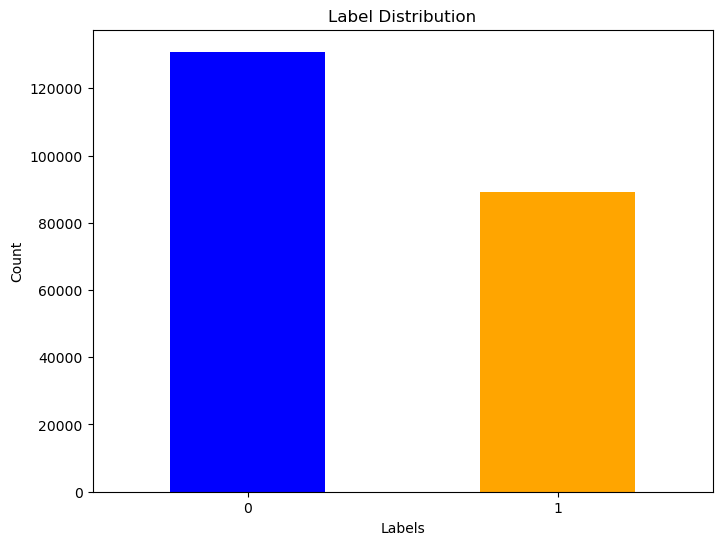

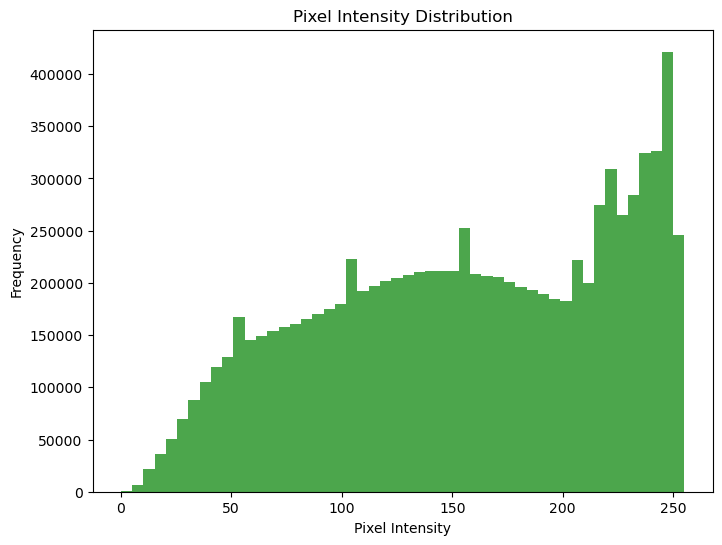

In [29]:
# EDA

# Function to load a subset of images and calculate pixel intensity
def load_images_and_pixels(image_folder, image_ids, num_samples = 500):
    pixel_values = []
    for img_id in image_ids[:num_samples]:
        img_path = os.path.join(image_folder, img_id)
        if os.path.exists(img_path):
            img = load_img(img_path, color_mode = 'grayscale') 
            img_array = img_to_array(img).flatten()  
            pixel_values.extend(img_array)
    return np.array(pixel_values)

# Plot histogram for label distribution
def plot_label_distribution(labels):
    plt.figure(figsize = (8, 6))
    labels.value_counts().plot(kind = 'bar', color = ['blue', 'orange'])
    plt.title("Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation = 0)
    plt.show()

# Plot histogram for pixel intensity
def plot_pixel_intensity(pixel_values):
    plt.figure(figsize = (8, 6))
    plt.hist(pixel_values, bins = 50, color = 'green', alpha = 0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Plotting label distribution
plot_label_distribution(labels_df['label'])

# Load and analyze a subset of images
num_samples = 1000  
sample_ids = labels_df['id'].tolist()
pixel_values = load_images_and_pixels(folder_path_train, sample_ids, num_samples=num_samples)

# Plotting pixel intensity distribution
plot_pixel_intensity(pixel_values)

Then, we rescale the data and keep 10% of the test set to create a validation set. We use tensorflow's flow_from_dataframe function to preprocess the data and have it all ready to be used by our deep learning model. We organize the images into batches of 64 as a balance between speed and memory (we tested several values and 64 seemed to provide the best results for the CPU used to perform the training). We also preprocess the test set in the same way. 

In [30]:
# ImageDataGenerator with validation split with 10% for validation
datagen = ImageDataGenerator(
    rescale = 1.0 / 255.0,
    validation_split = 0.1  
)

# Set the seed for reproducibility
seed = 42  

# Batch Size
batch_size = 64

# Adjust the target dimensions
size = 96
smaller_target_size = (size, size)

# Training set generator
train_generator = datagen.flow_from_dataframe(
    dataframe = labels_df,
    directory = folder_path_train,
    x_col = "id",
    y_col = "label",
    target_size = smaller_target_size,
    batch_size = batch_size,  
    class_mode = "binary",
    seed = seed,
    subset = 'training'  
)

# Validation set generator
val_generator = datagen.flow_from_dataframe(
    dataframe = labels_df,
    directory = folder_path_train,
    x_col = "id",
    y_col = "label",
    target_size = smaller_target_size,
    batch_size = batch_size,  
    class_mode = "binary",
    seed = seed,
    subset = 'validation'  
)

# Create a DataFrame for the test images
test_files = os.listdir(folder_path_test)
test_df = pd.DataFrame({
    'filename': test_files
})

# Instantiate the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)  

# Test set generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = folder_path_test,
    x_col = 'filename',
    y_col = None,  
    target_size = (size, size),  
    batch_size = batch_size,
    class_mode = None,  
    shuffle = False, 
    seed = seed
)

Found 198023 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


### Step 3: DModel Architecture

We employ a simple and standard Convolutional Neural Network architecture with two convolution layers and 2 max pooling layers as hidden layers. The input layer brings in the images which are RGB encoded with 96X96 pixels. We select a fairly low number of low-level features (16 to begin) in the first hidden layer and then increase this number to 32 in the next layer and then 64 in a final dense layer in order for the model to capture increasingly complex abstract features. The pooling layers will reduce the dimensions of the images every time, which reduces computational requirements and also risks of overfitting. The output layer only outputs a single value due to the binary classification nature of the problem. We also introduce a droput rate of 30% during training, again to reduce the risk of overfitting.

Because this model is fairly simple it will remain computationally efficient and allow me to complete this project within the timeframe allowed, without necessarily compromising too much accuracy. 

In [31]:
# Define the CNN model
model = Sequential([
    Input(shape=(size, size, 3)),  
    Conv2D(16, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'), 
    Dropout(0.3),  
    Dense(1, activation='sigmoid')  
])

### Step 4: Results and Analysis

Now we try our CNN model with 3 different learning rates to identify the best solution in terms of validation set accuracy. We plot the accuracy curves as a function of the number of epochs to visualize the training. We also use the ADAM optimizer to increase efficiency, along with an early stopping criterion. We notice that the results for a learning rate of 0.001 are good, reaching an accuracy of 87%, and that this cannot really be surpassed by multiplying or dividing the learning rate by 5. Indeed, the larger learning rate cannot get better accuracy and lower learning rate yields the same accuracy but needs more epochs.

Training with learning rate: 0.001
Epoch 1/10


/Users/lsaumier/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3095/3095 ━━━━━━━━━━━━━━━━━━━━ 529s 170ms/step - accuracy: 0.7696 - loss: 0.4881 - val_accuracy: 0.8322 - val_loss: 0.3822
Epoch 2/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 515s 166ms/step - accuracy: 0.8337 - loss: 0.3845 - val_accuracy: 0.8169 - val_loss: 0.4302
Epoch 3/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 516s 167ms/step - accuracy: 0.8558 - loss: 0.3409 - val_accuracy: 0.8666 - val_loss: 0.3184
Epoch 4/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 515s 166ms/step - accuracy: 0.8706 - loss: 0.3069 - val_accuracy: 0.8643 - val_loss: 0.3196
Epoch 5/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 509s 164ms/step - accuracy: 0.8825 - loss: 0.2820 - val_accuracy: 0.8727 - val_loss: 0.3078
Epoch 6/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 517s 167ms/step - accuracy: 0.8928 - loss: 0.2571 - val_accuracy: 0.8696 - val_loss: 0.3258
Epoch 7/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 511s 165ms/step - accuracy: 0.9015 - loss: 0.2378 - val_accuracy: 0.8714 - val_loss: 0.3129
Epoch 8/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 515s 166ms/step - accuracy: 0.9

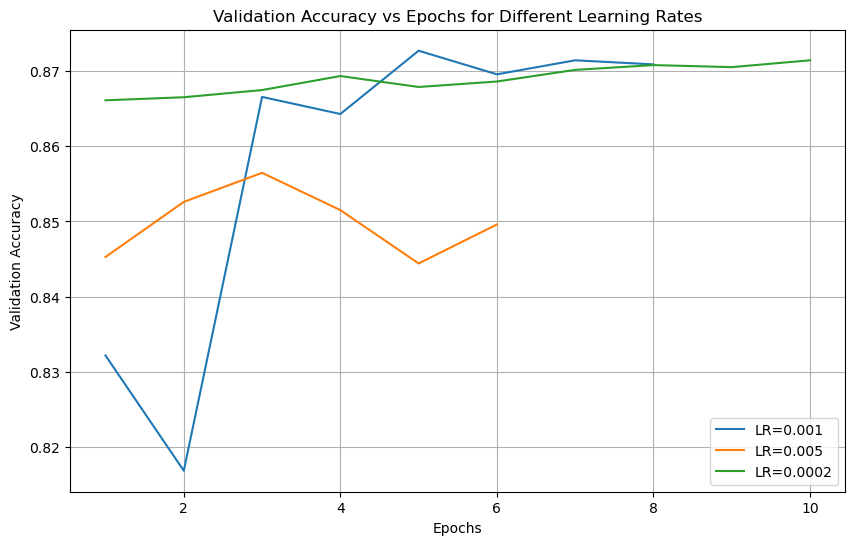

In [32]:
# Define a function to compile and train the model
def train_model_with_lr(model, train_generator, val_generator, learning_rate, epochs=10):
    # Compile the model with the specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )
    return history

# Learning rates to experiment with
learning_rates = [0.001, 0.005, 0.0002]

# Dictionary to store histories
histories = {}

# Loop through each learning rate and train the model
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    history = train_model_with_lr(model, train_generator, val_generator, learning_rate=lr)
    histories[lr] = history.history['val_accuracy']  

# Plot validation accuracy as a function of epochs for each learning rate
plt.figure(figsize=(10, 6))
for lr, val_acc in histories.items():
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=f"LR={lr}")
    
plt.title("Validation Accuracy vs Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Next, we try to increase the size of each layer (multiply number of features by 2) to see whether that will have an effect on the results. As we observe the answer is not better than the one obtained above.

In [33]:
# Define the CNN model
model2 = Sequential([
    Input(shape=(size, size, 3)),  
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.3),  
    Dense(1, activation='sigmoid')  
])

In [34]:
history2 = train_model_with_lr(model2, train_generator, val_generator, learning_rate=0.001)

Epoch 1/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 995s 321ms/step - accuracy: 0.7583 - loss: 0.5190 - val_accuracy: 0.8102 - val_loss: 0.4226
Epoch 2/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1045s 338ms/step - accuracy: 0.8155 - loss: 0.4121 - val_accuracy: 0.8412 - val_loss: 0.3686
Epoch 3/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 985s 318ms/step - accuracy: 0.8365 - loss: 0.3748 - val_accuracy: 0.8429 - val_loss: 0.3594
Epoch 4/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1052s 340ms/step - accuracy: 0.8491 - loss: 0.3504 - val_accuracy: 0.8532 - val_loss: 0.3384
Epoch 5/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1051s 340ms/step - accuracy: 0.8649 - loss: 0.3186 - val_accuracy: 0.8632 - val_loss: 0.3292
Epoch 6/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1051s 339ms/step - accuracy: 0.8822 - loss: 0.2854 - val_accuracy: 0.8594 - val_loss: 0.3347
Epoch 7/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1011s 327ms/step - accuracy: 0.8968 - loss: 0.2553 - val_accuracy: 0.8593 - val_loss: 0.3309
Epoch 8/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 945s 305ms/step

Finally, we see whether adding another hidden layer to the model will yield significantly better results. We add a third larger convolution layer as well another accompanying pooling layer. We see that we do actually gain about 3% in validation accuracy which is now above 90%, but at the expense of slower execution speed due to the more complex model.

In [36]:
# Define the CNN model
model3 = Sequential([
    Input(shape=(size, size, 3)),  
    Conv2D(16, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),  
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.3),  
    Dense(1, activation='sigmoid')  
])

In [37]:
history3 = train_model_with_lr(model3, train_generator, val_generator, learning_rate=0.001)

Epoch 1/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 611s 197ms/step - accuracy: 0.7698 - loss: 0.4794 - val_accuracy: 0.8392 - val_loss: 0.3759
Epoch 2/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 609s 197ms/step - accuracy: 0.8502 - loss: 0.3512 - val_accuracy: 0.8696 - val_loss: 0.3178
Epoch 3/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 611s 197ms/step - accuracy: 0.8760 - loss: 0.2986 - val_accuracy: 0.8878 - val_loss: 0.2735
Epoch 4/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 612s 198ms/step - accuracy: 0.8895 - loss: 0.2705 - val_accuracy: 0.8976 - val_loss: 0.2496
Epoch 5/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 613s 198ms/step - accuracy: 0.9003 - loss: 0.2466 - val_accuracy: 0.8987 - val_loss: 0.2517
Epoch 6/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 618s 200ms/step - accuracy: 0.9089 - loss: 0.2285 - val_accuracy: 0.9031 - val_loss: 0.2456
Epoch 7/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 615s 199ms/step - accuracy: 0.9174 - loss: 0.2101 - val_accuracy: 0.9051 - val_loss: 0.2420
Epoch 8/10
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 615s 199ms/step - ac

We now compute the confusion matrix for the validation set to determine what the error distribution of false positives and false negatives looks like. The distribution we get corresponds to a false positive rate of 5.35% and a false negative rate of 15.3%. Both are still quite substantial but the 15.3% of false negatives is fairly concerning since these would be cases of cancers that are missed by the algorithm. This suggests that we should further improve our model in the future. 

Found 22002 validated image filenames belonging to 2 classes.


/Users/lsaumier/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


344/344 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step
True labels distribution: [13120  8882]
Predicted labels distribution: [13777  8225]


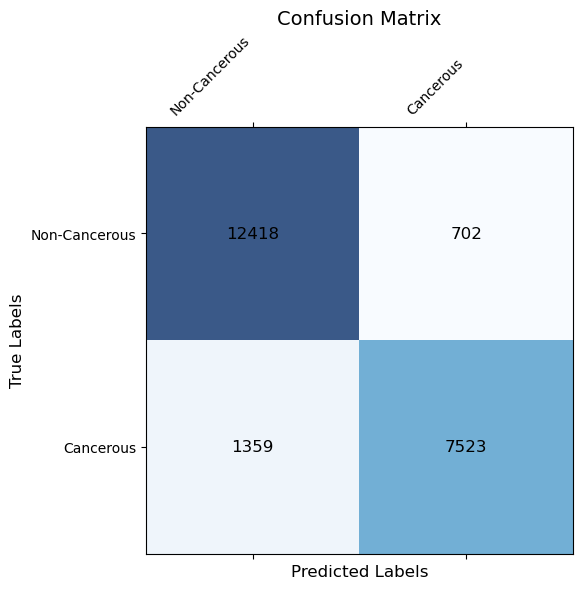

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Validation set generator (we need to reload it in order to get rid of the shuffling to get an accurate confusion matrix)
val_generator = datagen.flow_from_dataframe(
    dataframe = labels_df,
    directory = folder_path_train,
    x_col = "id",
    y_col = "label",
    target_size = smaller_target_size,
    batch_size = batch_size,  
    class_mode = "binary",
    seed = seed,
    subset = 'validation', 
    shuffle = False  
)

# Predict probabilities on the validation set
val_predictions = model3.predict(val_generator, verbose=1, steps=len(val_generator))

# Convert predictions to binary labels
predicted_labels = (val_predictions.flatten() > 0.5).astype(int)

# Extract true labels from the validation generator
true_labels = val_generator.classes

# Check the distribution of true and predicted labels
print("True labels distribution:", np.bincount(true_labels))
print("Predicted labels distribution:", np.bincount(predicted_labels))

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Define class names
class_names = ['Non-Cancerous', 'Cancerous']

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Display the matrix as a grid
    ax.matshow(cm, cmap="Blues", alpha=0.8)
    
    # Annotate each cell with its value
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', fontsize=12, color="black")
    
    # Set labels
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(class_names)), class_names, fontsize=10)
    
    # Axis labels
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_confusion_matrix(cm, ['Non-Cancerous', 'Cancerous'])

### Step 5: Conclusion

We have now obtained a good model by carefully selecting the learning rate and by experimenting with different number and density of layers in the model architecture. We have selected a model with 3 hidden convolution layers accompanied by 3 maxpooling layers, which yielded an accuracy of roughly 90% on the validation set. 

In the future we should attempt to improve the performance of this model by adding more hidden layers, or by experimenting with different strategies such as average pooling, in order to address the fairly high rate of false negatives. We could also use transfer learning to initialize models with more layers in order to speed up the process. In any case, in order to complete this assignment on time, we are now ready to produce the test set predictions for submission on Kaggle. 

In [84]:
# Instantiate the ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path_test,
    x_col='filename',
    y_col=None,
    target_size=(size, size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

test_generator.reset()

max_batches = len(test_generator) 
test_predictions = []

# I had to manually predict batch by batch here and force stop when done because 
# somehow the predict function was not working when applied to the whole test data at once
for i, batch in enumerate(tqdm(test_generator, total=max_batches, desc="Predicting")):
    if i >= max_batches:  # Stop manually after 898 batches
        print(f"Stopping after {max_batches} batches.")
        break
    preds = model3.predict(batch, verbose=0)
    test_predictions.extend(preds)

test_predictions = np.array(test_predictions)

# Convert probabilities to binary labels
predicted_labels = (test_predictions > 0.5).astype(int)

# Save predictions to a DataFrame
test_filenames = test_generator.filenames
results_df = pd.DataFrame({
    'id': [os.path.basename(f).split('.')[0] for f in test_filenames],
    'label': predicted_labels.flatten()
})

# Save to CSV
results_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Found 57458 validated image filenames.


Predicting: 100%|█████████████████████████████| 898/898 [02:59<00:00,  5.01it/s]


Stopping after 898 batches.
Predictions saved to submission.csv


Here we simply upload the submission file to ensure it is in the correct format before submitting.

In [86]:
# Load the submission.csv file
submission_df = pd.read_csv('submission.csv')

# Inspect the first few rows of the dataframe
print(submission_df.head(20))

# Check the number of rows in the submission (it should match the number of test samples)
print(f"Number of predictions in submission.csv: {len(submission_df)}")

# Optionally, ensure the 'id' and 'label' columns are as expected
print(submission_df.columns)

                                          id  label
0   fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1   1f9ee06f06d329eb7902a2e03ab3835dd0484581      0
2   19709bec800f372d0b1d085da6933dd3ef108846      0
3   7a34fc34523063f13f0617f7518a0330f6187bd3      0
4   93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
5   761dde7de22cb39a0dd67ce472163d66e5ac1568      1
6   58055ce8819717a100b48d019e139be4fdf997c0      0
7   9735b584631f4b942b022d40aecdbe2aa8f6ae5e      0
8   860bbd33f8483a45858c4998021bc7434117deda      0
9   99050fbce64ae16e48e8a3b09d38f3b16df63fbe      1
10  3091e877b92112604324f4af82735f64cf07a50c      1
11  9b2ee1deca30e1d7c8e515d620aff1b137ba4474      0
12  8f15b3139e3ff9e60d2a6305b57d90b21e48a378      0
13  1f9fe04059309fb60e5db14bd8a38d059935f563      0
14  b9ece5c8fbd1564c1748fd9a3d7ed2a5b415518e      1
15  706eaf697e8e5cbd3bd97229a097d7452a6f2441      1
16  a4565425b5bd53063031eaa93ccfbc40925702a5      1
17  e9e499f23d9d35a25400ae31c5812e85cd7e1795      0
18  b25a3102